In [463]:
__author__ = 'lisette.espin'

%matplotlib inline
#%config InlineBackend

################################################################################
### Dependencies
################################################################################
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
from collections import defaultdict
import numpy as np
import copy
import warnings
from scipy.special import gammaln, gamma
from random import randint, uniform, randrange
from scipy.sparse import coo_matrix
import operator
import sys
import copy
from random import shuffle
from lea import *

################################################################################
### CONSTANTS
################################################################################
NODES = 50                                 # number of nodes
EDGES = NODES - 1                          # number of edges (barabassi)
RADIUS = 1.0                               # radius for geometric graph
DIRECTED = True                            # True if directed graph, False otherwise
WEIGHTED = True                            # True if weighted graph, False otherwise
GLOBAL = False                             # True if global matrix-based norm, local row-based otherwise
NORM = True                                # True if matrix of beliefs needs to be normalized
MODE = 'integers'                          # integers or reals pseudo counts
K = 10                                     # maximun weighting factor k
WEIGHTING_FACTORS = np.logspace(-1,K,K+2)  # range of k values
Kprint = 100000                            # k value to print (ranked hypotheses)
P = 0.5                                    # probability of edge formation   
MINW = 1.                                  # min value of edge weights
MAXW = 100.                                # max value of edge weights
ALGO = 'random-walk'                       # erdos-renyi, geometric, barabassi, uniform, random-walk
UNIFORM = 1/float(NODES-1)                 # prob for uniform

In [464]:
################################################################################
### Main Class: JANUS
################################################################################
class JANUS(object):
    def __init__(self):
        self.hypotheses = {}  # hypotheses (hypothesis_name:janusmatrix)
        self.evidences = {}   # evidence values (hypothesis_name:{k:value})
        self.model = None     # categorical
        self.data = None      # janus matrix
        
    def setMatrix(self, m, isdata):
        if isdata:
            self.setData(m,True)
        else:
            self.addHypothesis(m.name,m)
            
    def createMatrix(self,name,algorithm,isdirected,isweighted,isglobal,norm,mode,isdata,**kwargs):
        m = JanusMatrix(name,algorithm,isdirected,isweighted,isglobal,norm,mode,**kwargs)
        m.createGraph()
        
        if isdata:
            self.setData(m,True)
        else:
            self.addHypothesis(name,m)
            
        return m
    
    def setData(self,janusmatrix,showInfo=False):
        self.data = janusmatrix
        self.hypotheses['data'] = self.data
        self.setVocabulary()
        if showInfo:
            self._showInfoData()
        
    def _plotDegreeDistribution(self):           
        degree_sequence=sorted(nx.degree(self.data.G).values(),reverse=True) # degree sequence
        #rint 'degree: ', nx.degree(self.data.G)
        #rint "Degree sequence", degree_sequence
        #max=max(degree_sequence)
        plt.plot(degree_sequence,'b-',marker='o')
        plt.title("Degree rank plot")
        plt.ylabel("degree")
        plt.xlabel("rank")
        plt.show()
        plt.close()
        
    def _plotGraph(self):
        pos = nx.spring_layout(self.data.G)
        
        if self.data.algorithm == 'random-walk':
            
            for c in self.data.colors:
                # nodes
                nx.draw_networkx_nodes(self.data.G,pos,
                                       nodelist=[node[0] for node in self.data.G.nodes(data=True) if node[1]['color'] == c],
                                       node_color=c,
                                       node_size=50,
                                   alpha=0.8)
                # edges
                nx.draw_networkx_edges(self.data.G,pos,width=1.0,alpha=0.5)
        else:
            nx.draw(self.data.G)
                                                 
        plt.show()
        
    def _showInfoData(self):
        self._plotGraph()
        self._plotDegreeDistribution()
        print nx.info(self.data.G)

    def copyWithNoise(self, janusmatrix, noise):
        '''
        Given a matrix D (adjacency matrix of a graph G) it adds random noise into its cells.
        The noise is a random number from 0 to noise if the matrix is unweighted.
        For weighted graphs the noise goes from -noise to noise.
        returns csr_matrix
        '''
        H = JanusMatrix(name=janusmatrix.name, algorithm=janusmatrix.algorithm, isdirected=janusmatrix.isdirected, isweighted=janusmatrix.isweighted, isglobal=janusmatrix.isglobal, norm=janusmatrix.norm, mode=janusmatrix.mode, n=janusmatrix.n, p=janusmatrix.p, m=janusmatrix.m, r=janusmatrix.r, minw=janusmatrix.minw, maxw=janusmatrix.maxw, noise=noise)
        H.G = janusmatrix.G.copy()
        H.D = janusmatrix.D.copy()
        H.M = janusmatrix.M.copy()
        H.updateAdjacencyMatrix()
        
        self.addHypothesis('noise-{}'.format(noise),H)
        return H
    
    def setVocabulary(self):
        self.vocabulary = {str(n):i for i,n in enumerate(nx.nodes(self.data.G))}

    def addHypothesis(self, key, janusmatrix):
        self.hypotheses[key] = janusmatrix
        
    def setCategoricalDistribution(self, use_prior=False, prior=1., modus='bayes', isdirected=False):
        self.model = CategoricalDistribution(use_prior=True, prior=1., specific_prior_vocab = self.vocabulary, modus='bayes', isdirected=DIRECTED)
        self.model.prepare_data(self.data.G)
        self.model.fit(self.data.G)

    def generateEvidences(self, weighting_factors):
        for id,hg in self.hypotheses.items():
            self.evidences[id] = {}
            for k in weighting_factors:
                prior = hg.elicit_prior(k)
                if prior is not None:
                    self.model.setSpecificPrior(prior)
                    e = self.model.evidence()
                    self.evidences[id][k] = e
        
    def showRank(self, k):
        rank = {}
        for hname,evidencesobj in self.evidences.items():
            if k in evidencesobj:
                v = float(evidencesobj[k])
                if not np.isnan(v):
                    rank[hname] = v
                else:
                    print hname

        sortedr = sorted(rank.items(), key=operator.itemgetter(1),reverse=True)
        print 'Data generated as {} with p={}'.format(self.data.algorithm,self.data.p)
        print '===== RANK ====='
        print '\n'.join(['{0:25s}{1:<.5f}'.format(str(e[0]),float(e[1])) for e in sortedr])

    def plot_csr_matrix(self,m,title,fig,ax,k):
        if not isinstance(m, csr_matrix):
            m = csr_matrix(m)
        heatmap = ax[k-1].pcolor(m.toarray(), cmap='PuBu') #, norm=colors.LogNorm(vmin=m.min(), vmax=m.max()))
        ax[k-1].invert_yaxis()
        # Move spines outward by 10 points
        ax[k-1].spines['left'].set_position(('outward', 5))
        ax[k-1].spines['top'].set_position(('outward', 5))
        # Hide spines
        ax[k-1].spines['right'].set_visible(False)
        ax[k-1].spines['bottom'].set_visible(False)
        # Only show ticks on the left and bottom spines
        ax[k-1].yaxis.set_ticks_position('left')
        ax[k-1].xaxis.set_ticks_position('top')
        fig.tight_layout()

        if k == ax.shape[0]:
            cbar = fig.colorbar(heatmap, extend='max')
            cbar.ax.set_ylabel('prior')
            plt.suptitle(title)
            plt.subplots_adjust(top=0.85)

    def plotEvidences(self):
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(111)
        fig.canvas.draw()

        counter = 0
        for hname,evistyobj in self.evidences.items():

            ### Adding hyoptheses in plot
            xx,yy = self._addEvidenceToPlot(evistyobj,counter,ax,hname)
            counter += 1

        ### Finishing Plot
        plt.title('Evidences')
        ax.set_xlabel("hypothesis weighting factor k")
        ax.set_ylabel("evidence")
        plt.grid(False)
        ax.xaxis.grid(True)

        # Shrink current axis by 20%
        plt.legend(loc=3)
        plt.show()
        plt.close()

    def _addEvidenceToPlot(self,evidencesobj, styleid, ax, label):
        sortede = sorted(evidencesobj.items(), key=operator.itemgetter(0),reverse=False)
        yy = [e[1] for e in sortede]
        xx = [e[0] for e in sortede]
        ax.semilogx(xx, yy, marker='*', label=label)
        return xx,yy
    

In [465]:
################################################################################
### Class: Matrix (data and priors)
################################################################################
class JanusMatrix(object):
    def __init__(self,name,algorithm,isdirected,isweighted,isglobal,norm,mode,**kwargs):
        self.name = name
        self.algorithm = algorithm
        self.isdirected = isdirected
        self.isweighted = isweighted
        self.isglobal = isglobal
        self.norm = norm
        self.mode = mode
        self.n = None if 'n' not in kwargs else kwargs['n']
        self.p = None if 'p' not in kwargs else kwargs['p']
        self.m = None if 'm' not in kwargs else kwargs['m']
        self.r = None if 'r' not in kwargs else kwargs['r']
        self.minw = None if 'minw' not in kwargs else kwargs['minw']
        self.maxw = None if 'maxw' not in kwargs else kwargs['maxw']
        self.noise = None if 'noise' not in kwargs else kwargs['noise']
        self.colors = None if 'colors' not in kwargs else kwargs['colors']
        self.probabilities = None if 'probabilities' not in kwargs else kwargs['probabilities']
        
        self.G = None
        self.D = None
        self.M = None
        
    ############################################################################
    ### Graph generators
    ############################################################################
    
    @staticmethod
    def create(G,name,isdirected,isweighted,isglobal,norm,mode):
        m = JanusMatrix(name,None,isdirected,isweighted,isglobal,norm,mode) 
        m.G = G
        m.D = nx.adjacency_matrix(m.G,weight='weight')
        m.M = csr_matrix(m.D, dtype=np.float64)
        m.M.setdiag(m.M.diagonal()*0.)
        return m
        
        
    def createGraph(self):
        if self.isweighted:
            self.createRandomWeightedGraph()
            self.D = nx.adjacency_matrix(self.G)
        else:
            self.createRandomUnweightedGraph()
            self.D = nx.adjacency_matrix(self.G,weight='weight')
            
        self.M = csr_matrix(self.D, dtype=np.float64)
        self.updateAdjacencyMatrix()
        
    def updateAdjacencyMatrix(self):
        self._checkIfNoise()
        self.M.setdiag(self.M.diagonal()*0.)
        
        
    def _checkIfNoise(self):
        if self.noise is not None:
            cx = coo_matrix(self.D, dtype=np.float64)
            for i,j,v in zip(cx.row, cx.col, cx.data):
                if self.isweighted:
                    noise = uniform(self.noise*-1,self.noise)
                    noise = int(noise)
                    self.M[i,j] = v + noise
                else:
                    noise = uniform(0,self.noise)
                    noise = int(noise)
                    self.M[i,j] = v + (noise if v == 0 else noise*-1) ### is this correct?
            
            self.M[self.M < 0.] = 0.
            if not self.isweighted:
                self.M[self.M > 1.] = 1.
                
    def _graph_generator(self,G=None):
        '''
        Calls the respective graph generator functions according to algorithm
        '''
        if self.algorithm == 'erdos-renyi':
            self.G = nx.erdos_renyi_graph(n=self.n, p=self.p, directed=self.isdirected)
        elif self.algorithm == 'barabassi':
            self.G = nx.barabasi_albert_graph(n=self.n, m=self.m)
        elif self.algorithm == 'geometric':
            self.G = nx.random_geometric_graph(n=self.n, radius=self.r)
        elif self.algorithm == 'uniform':
            self.G = nx.complete_graph(n=self.n)
        elif self.algorithm == 'random-walk':
            self.G = RandomWalkGraph(nnodes=NODES,colors=self.colors,probabilities=self.probabilities,isdirected=self.isdirected,isweighted=self.isweighted).createGraph()
        else:
            print 'ERROR {} algorithm does NOT exist.'.format(self.algorithm)

    def createRandomUnweightedGraph(self):
        '''
        Creates a random graph. Linkages are made according to algorithm (erdos,barabassi,etc.)
        '''
        self._graph_generator()
        
    def createRandomWeightedGraph(self):
        '''
        Creates a random graph. Linkages are made according to algorithm (erdos,barabassi,etc.)
        Weights are inferred at random from minw to maxw, both inclusive.
        '''
        self.createRandomUnweightedGraph()
        
        if self.algorithm != 'random-walk':
            for u,v,d in self.G.edges(data=True):
                w = self.p if self.algorithm == 'uniform' else randint(self.minw,self.maxw)
                self.G[u][v]['weight'] = w
        
    ############################################################################
    ### Priors (Beliefs)
    ############################################################################
    
    def elicit_prior(self, k):
        if k == 0.1:
            return csr_matrix(self.D.shape, dtype=np.float64)
        elif self.isglobal:
            return self.elicit_prior_global(k)
        return self.elicit_prior_local(k)
            
            
    def elicit_prior_global(self, k):
        '''
        Eliciting prior (beliefs)
        Normalizing Globally (matrix-based)
        '''
        if self.norm:
            matrix_sum = self.M.sum()
            if matrix_sum > 0:
                prior = self.M / matrix_sum
            else:
                prior = None
                print 'WARNING: Your matrix {} contains only zeros.'.format(self.name)

        if self.mode == "integers" and prior is not None:
            prior = prior * k

        return prior
    
    def elicit_prior_local(self, k):
        '''
        Eliciting prior (beliefs)
        Normalizing Locally (row-based)
        '''
        if self.norm:
            matrix_sum_rows = self.M.sum(axis=1)
            
            if np.all(matrix_sum_rows > 0):
                prior = csr_matrix(self.M.toarray() / matrix_sum_rows)
            else:
                prior = None
                print 'WARNING: Your matrix {} contains only zeros row-wise.'.format(self.name)

        if self.mode == "integers" and prior is not None:
            prior = prior * k

        return prior
    

In [466]:
################################################################################
### Model Class: Likelihood
################################################################################

class CategoricalDistribution(object):
    
    def __init__(self, use_prior=False, prior=1., specific_prior_vocab = None, modus='bayes', isdirected=False):
        '''
        Constructor
        :param use_prior: flag if script should use a prior
        :param prior: prior (pseudo count) for each single element (in case of MLE it is smoothing)
        Note that usually the values should directly represent the additional alpha values for corresponding elements.
        :param specific_prior_vocab: dictionary of vocabulary that matches state names with indices
        of the specific_prior matrix
        :param modus: specifies the modus of the class, there are two possibilities: modus='mle' is focused on working
        with mle matrices representing probabilities
        :param  modus: 'bayes' focuses on working with bayesian evidence and only works with plain transition counts
        '''

        self.nodes_count_ = len(specific_prior_vocab)
        self.parameter_count_ = 0
        self.observation_count_ = 0

        #probabilities
        self.edges_dict_ = defaultdict(lambda : defaultdict(float))
        self.edges_dict_norm_ = None

        self.prediction_position_dict_ = dict()
        self.dtype_ = np.dtype(float)
        self.modus_ = modus
        self.isdirected = isdirected

        self.use_prior_ = use_prior
        self.alpha_ = prior
        
        self.specific_prior_vocab_ = specific_prior_vocab

        self.proba_from_unknown_ = 0
        self.proba_to_unknown_ = dict()

    def prepare_data(self, G):
        '''
        Function for preparing the data
        ALWAYS CALL FIRST
        :param G: graphs (networkx) including all nodes and edges
        '''

        # unique nodes
        nodes = nx.nodes(G)

        self.nodes_initial_ = frozenset(nodes)

        if self.nodes_count_ < float(len(nodes)):
            raise Exception("You set the nodes_count too low!")

        # number of unique nodes
        if self.nodes_count_ is None:
            self.nodes_count_ = float(len(nodes))

    def fit(self, G):
        '''
        Fitting the data and constructing MLE
        :param G: graphs (networkx) including all nodes and edges
        '''

        nodes = nx.nodes(G)
        for n1 in nodes:
            for n2 in nodes:
                self.edges_dict_[tuple([str(n1)])][str(n2)] = 0.

        edges = G.edges(data=True)
        for (i,j,d) in edges:
            self.edges_dict_[tuple([str(i)])][str(j)] += d['weight'] if 'weight' in d else 1.

            if not self.isdirected:
                self.edges_dict_[tuple([str(j)])][str(i)] += d['weight'] if 'weight' in d else 1.

    def setSpecificPrior(self, specific_prior):
        '''
        :param specific_prior: sparse matrix of specific alpha configurations (can also be a hdf5 matrix)
        '''        
        self.specific_prior_ = specific_prior
        if self.specific_prior_ is not None and self.specific_prior_vocab_ is None:
            raise Exception("Can't work with a specific alpha without vocabulary information!")
        if self.specific_prior_ is not None and self.modus_ != "bayes":
            raise Exception("Specific alpha only works mit Bayes modus!")

    def evidence(self):
        '''
        Calculating the bayesian evidence
        Not every single exception case is tackled in the code of this function.
        It is the responsibility of the user that---if used---the specific prior matrix is appropriately shaped and set.
        :return: Bayesian evidence (marginal likelihood)
        '''

        if self.modus_ != "bayes":
            raise Exception("Bayesian evidence does not work with modus='mle'")

        single_row = False
        is_hdf5 = False
        is_csr = False
        if self.specific_prior_ is not None:
            if isinstance(self.specific_prior_, csr_matrix):
                is_csr = True
                if self.specific_prior_.shape[0] != self.specific_prior_.shape[1]:
                    warnings.warn("Specific alpha dimensions are not the same. Only appropriate if one the matrix is 1xN for setting each row the same! Only works for csr_matrix!")
                if self.specific_prior_.shape[0] ==  1:
                    single_row = True
                if self.specific_prior_.shape[1] < self.nodes_count_:
                    raise Exception("your specific prior needs to at least cover all states in the trails, shape mismatch")
            else:
                raise Exception("wrong specific prior format")

        enum_1 = 0
        denom_1 = 0
        enum_2 = 0
        denom_2 = 0

        for k,v in self.edges_dict_.iteritems():

            #start with combining prior knowledge with real data
            cx = None
            if self.specific_prior_ is not None:
                if single_row:
                    cx = self.specific_prior_
                else:
                    if is_csr:
                        cx = self.specific_prior_.getrow(self.specific_prior_vocab_[k[0]])
                    elif is_hdf5:
                        row = self.specific_prior_vocab_[k[0]]
                        indptr_first = self.specific_prior_.indptr[row]
                        indptr_second = self.specific_prior_.indptr[row+1]
                        data = self.specific_prior_.data[indptr_first:indptr_second]
                        indices = self.specific_prior_.indices[indptr_first:indptr_second]
                        indptr = np.array([0,indices.shape[0]])

                        shape = (1, self.nodes_count_)
                        cx = csr_matrix((data, indices, indptr), shape=shape)

            #n_sum = sum(v.values())
            #if n_sum == 0.:
            #    raise Exception("The row sum should not be zero, something went wrong here!")

            for x, c in v.iteritems():
                idx = self.specific_prior_vocab_[x]
                prior = self.alpha_ + cx[0, idx]

                enum_1 += prior
                denom_1 += prior + c

                enum_2 += gammaln(prior + c)
                denom_2 += gammaln(prior)

        evidence = gammaln(enum_1) + enum_2 - gammaln(denom_1) - denom_2
        return evidence

In [467]:
################################################################################
### Initialization 
################################################################################
class RandomWalkGraph(object):
    def __init__(self,nnodes,colors,probabilities,isdirected,isweighted):
        self.nnodes = nnodes
        self.colors = colors
        self.probabilities = probabilities
        self.isdirected = isdirected
        self.isweighted = isweighted
        self.colordistribution = {}
        
    def validate(self):
        if set([c for c,p in self.colors.items()]) == set(self.probabilities.keys()) == set([k for av,obj in self.probabilities.items() for k in obj.keys()]):
            return True
        print 'Error: There is no enough information to generate the graph.'
        return False
    

    def plotColorDistribution(self):         
        data = {}
        
        fig, ax = plt.subplots()
        for v1, vobj in self.colordistribution.items():
            for v2, nedges in vobj.items():
                label = '{}-{}'.format(v1,v2)
                if label not in data:
                    data[label] = 0
                data[label] += nedges
        
        x = range(len(data.keys()))
        ax.bar(x, data.values(), 0.35, color='r')
        ax.set_ylabel('# Edges')
        ax.set_xlabel('Colors')
        ax.set_xticks(x)
        ax.set_xticklabels(data.keys())
        ax.set_title('Distribution of Edges per Color')
        plt.show()
        plt.close()            

        
    def createGraph(self):
        if self.validate():
            
            if self.isweighted:
                G = nx.MultiDiGraph() if self.isdirected else nx.MultiGraph()
            else:
                G = nx.DiGraph() if self.isdirected else nx.Graph()
            
            for t in range(1):
                
                ### Adding nodes with attributes               
                nodes = Lea.fromValFreqsDict({c:p for c,p in self.colors.items()})
                dist = nodes.random(self.nnodes)

                for n,value in enumerate(dist):
                    G.add_node(n, color=value)
                
                
                ### Adding edges 
                for n1 in G.nodes(data=True):
                    for a1,v1 in n1[1].items():
                        
                        probs = self.probabilities[v1]
                        for v2,p12 in probs.items():
                            
                            othernodes = [n[0] for n in G.nodes(data=True) if n[1][a1] == v2 and n[0] != n1[0]]
                            dist = np.random.binomial(n=1,p=p12,size=len(othernodes))
                                
                            for i2, link in enumerate(dist):
                                if link == 1:
                                    G.add_edge(n1[0], othernodes[i2])
                                    
                                    if v1 not in self.colordistribution:
                                        self.colordistribution[v1] = {}
                                    if v2 not in self.colordistribution[v1]:
                                        self.colordistribution[v1][v2] = 0
                                    self.colordistribution[v1][v2] += 1
                   
                          
                self.plotColorDistribution()
                return G
        return None

In [468]:
################################################################################
### Initialization 
################################################################################
janus = JANUS()

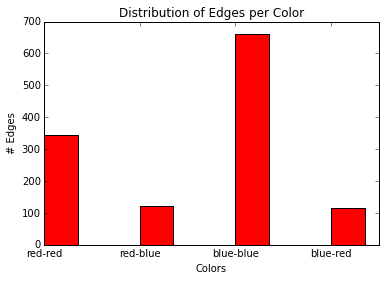

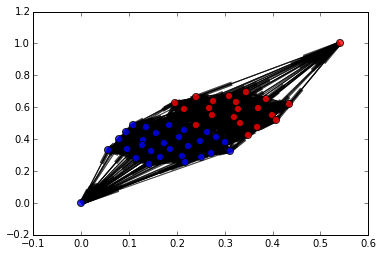

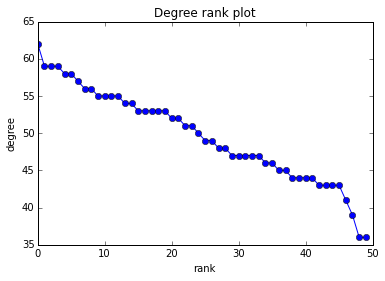

Name: 
Type: MultiDiGraph
Number of nodes: 50
Number of edges: 1242
Average in degree:  24.8400
Average out degree:  24.8400


In [469]:
################################################################################
### Dataset: Random Graph (Erdos_renyi_graph, binomal)
################################################################################
janus.createMatrix(name='random-walk',algorithm=ALGO,isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,isdata=True,n=NODES,colors={'red':50,'blue':50},probabilities={'red':{'red':.80,'blue':.20},'blue':{'red':.20,'blue':.80}})

In [470]:
################################################################################
### Generating hypothesis Graphs
################################################################################
def generateGraph(attributed_nodes, isweighted, isdirected, probabilites):
    G = nx.DiGraph() if isdirected else nx.Graph()
    
    ### Adding edges 
    nnodes = len(attributed_nodes)
    for i1,n1 in enumerate(attributed_nodes): # n1 tuple (node_name, dictionary_attributes): (0, {'color':'red'})
        node1 = n1[0] 
        att1 = n1[1]['color']
        
        for i2 in range(i1+1 if not isdirected else 0,nnodes):
            n2 = attributed_nodes[i2]
            node2 = n2[0] 
            att2 = n2[1]['color']
            
            w = probabilites[att1][att2]
            
            if isweighted:
                G.add_edge(node1, node2, weight=w) 
                if not isdirected:
                    G.add_edge(node2, node1, weight=w) 
            else:
                G.add_edge(node1, node2)
                if not isdirected:
                    G.add_edge(node2, node1) 

    return G

In [471]:
################################################################################
### Hypotheses (creation)
################################################################################
attributed_nodes = janus.data.G.nodes(data=True)
janus.createMatrix(name='uniform-{0:.2f}'.format(UNIFORM),algorithm='uniform',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE,isdata=False,n=NODES,p=UNIFORM)
janus.setMatrix(m=JanusMatrix.create(generateGraph(attributed_nodes,DIRECTED,WEIGHTED,{'red':{'red':100,'blue':0},'blue':{'red':0,'blue':100}}),'100Homophily-0Heterophily',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE), isdata=False)
janus.setMatrix(m=JanusMatrix.create(generateGraph(attributed_nodes,DIRECTED,WEIGHTED,{'red':{'red':100,'blue':10},'blue':{'red':10,'blue':100}}),'100Homophily-10Heterophily',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE), isdata=False)
janus.setMatrix(m=JanusMatrix.create(generateGraph(attributed_nodes,DIRECTED,WEIGHTED,{'red':{'red':80,'blue':20},'blue':{'red':20,'blue':80}}),'80Homophily-20Heterophily',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE), isdata=False)
janus.setMatrix(m=JanusMatrix.create(generateGraph(attributed_nodes,DIRECTED,WEIGHTED,{'red':{'red':20,'blue':80},'blue':{'red':80,'blue':20}}),'20Homophily-80Heterophily',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE), isdata=False)
janus.setMatrix(m=JanusMatrix.create(generateGraph(attributed_nodes,DIRECTED,WEIGHTED,{'red':{'red':80,'blue':20},'blue':{'red':80,'blue':20}}),'80ToRed-20ToBlue',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE), isdata=False)
janus.setMatrix(m=JanusMatrix.create(generateGraph(attributed_nodes,DIRECTED,WEIGHTED,{'red':{'red':20,'blue':80},'blue':{'red':20,'blue':80}}),'80ToBlue-20ToRed',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE), isdata=False)
janus.setMatrix(m=JanusMatrix.create(generateGraph(attributed_nodes,DIRECTED,WEIGHTED,{'red':{'red':1,'blue':0},'blue':{'red':1,'blue':0}}),'ToRedOnly',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE), isdata=False)
janus.setMatrix(m=JanusMatrix.create(generateGraph(attributed_nodes,DIRECTED,WEIGHTED,{'red':{'red':0,'blue':1},'blue':{'red':0,'blue':1.}}),'ToBlueOnly',isdirected=DIRECTED,isweighted=WEIGHTED,isglobal=GLOBAL,norm=NORM,mode=MODE), isdata=False)
janus.copyWithNoise(janus.data, 1.)
janus.copyWithNoise(janus.data, 5.)
janus.copyWithNoise(janus.data, 10.)
janus.copyWithNoise(janus.data, 100.)
janus.copyWithNoise(janus.data, 1000.)

In [472]:
################################################################################
### Evidences
################################################################################

### Modelling Linkage in data graph
janus.setCategoricalDistribution(use_prior=True, prior=1., modus='bayes', isdirected=DIRECTED)

### Generating Evidences for each hypothesis and value of k 
janus.generateEvidences(WEIGHTING_FACTORS)        

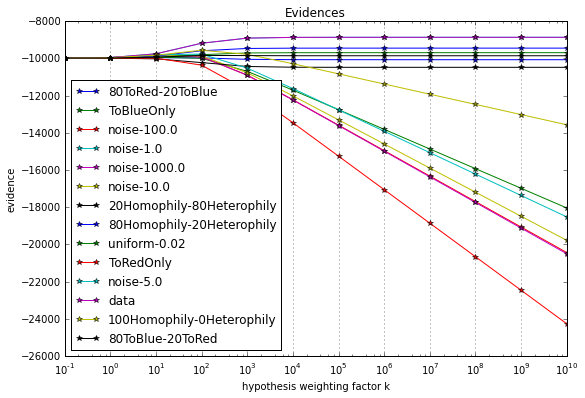

In [473]:
janus.plotEvidences()

In [474]:
################################################################################
### Summary: Rank
################################################################################
janus.showRank(Kprint)

Data generated as random-walk with p=None
===== RANK =====
noise-1.0                -8866.07331
data                     -8866.07331
80Homophily-20Heterophily-9447.94797
uniform-0.02             -9692.53984
80ToBlue-20ToRed         -9857.38778
80ToRed-20ToBlue         -10069.89573
20Homophily-80Heterophily-10479.33554
100Homophily-0Heterophily-10829.11703
ToBlueOnly               -12757.15217
noise-5.0                -12765.98229
noise-10.0               -13303.69331
noise-100.0              -13588.36442
noise-1000.0             -13609.20579
ToRedOnly                -15254.68714


In [475]:
print 'red: ', len([n for n in janus.data.G.nodes(data=True) if n[1]['color'] == 'red'])
print 'blue: ', len([n for n in janus.data.G.nodes(data=True) if n[1]['color'] == 'blue'])

red:  21
blue:  29
